# Проект: определение возраста человека по фото
**Цель** - обучить модель, которая сможет оценивать возраст посетителей супермаркета по внешности, чтобы предлагать потенциально интересные товары и контролировать соблюдение кассирами запрета на продажу алкоголя несовершеннолетним.

Для решения задачи компьютерного зрения нам лучше всего подойдут **нейросети**: изображения содержат слишком большое количество признаков, чтобы пытаться работать с ними при помощи классических алгоритмов.

## 1. Первичное изучение данных
Посмотрим на то, какие у нас имеются фотографии.

In [1]:
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import seaborn as sns

У нас есть датафрейм, в котором содержится информация о фотографиях и возрасте людей, на них изображённых.

In [2]:
labels = pd.read_csv('/datasets/faces/labels.csv')

Выведем датафрейм, чтобы лучше представлять структуру данных и понимать, как настраивать наш загрузчик данных.

In [3]:
labels.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


Понятно: первый столбец отвечает за имя файла, а второй - за целевой признак.

Что можно в целом сказать о датасете?

In [4]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
file_name    7591 non-null object
real_age     7591 non-null int64
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


- Как видим, в датасете 7591 объект.
- Пропусков нет.
- Типы данных вполне соответствуют тем признакам, которые они описывают.

Посмотрим на то, какое распределение имеет возраст.

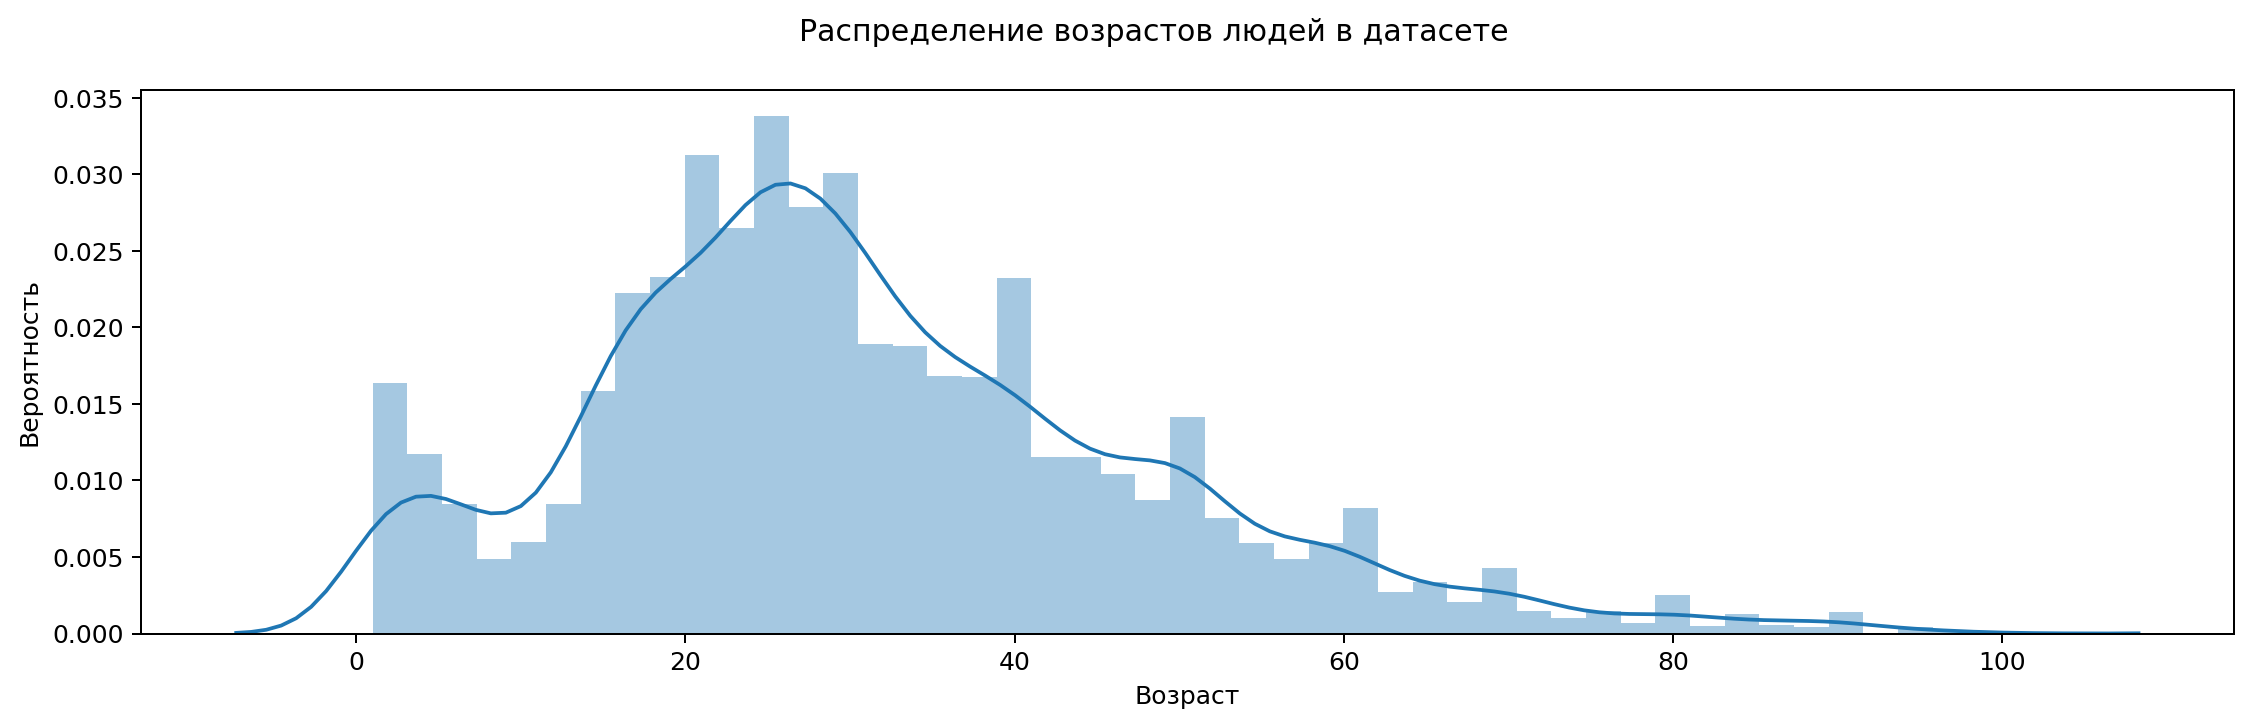

In [5]:
# Рисуем гистограмму с плотностью вероятностей,
# потому что у нас неполный датасет.
plt.figure(figsize=(15, 4), dpi=180)
sns.distplot(labels.real_age)
plt.xlabel('Возраст')
plt.ylabel('Вероятность')
plt.suptitle('Распределение возрастов людей в датасете')
plt.show()
plt.close()

Интересно, почему в распределении реже встречаются дети в возрасте около 9 лет. Видимо, так собран наш набор данных.

Посмотрим на фотографии из обучающей выборки. Но сперва их загрузим.

In [6]:
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw'
)

Found 7591 validated image filenames.


In [7]:
# Возьмём из итератора один батч
images = next(train_gen_flow)

In [8]:
# Посмотрим на размер батча с изображениями
images[0].shape

(32, 224, 224, 3)

Видим 32 картинки размером *224*\**224* пикселя, и каждый пиксель состоит из 3 значений: красный, зелёный, синий.

Используем `Matplotlib` для отображения фотографий.

In [9]:
def remove_ticks():
    """Убирает оси с изображения."""
    plt.xticks([])
    plt.yticks([])

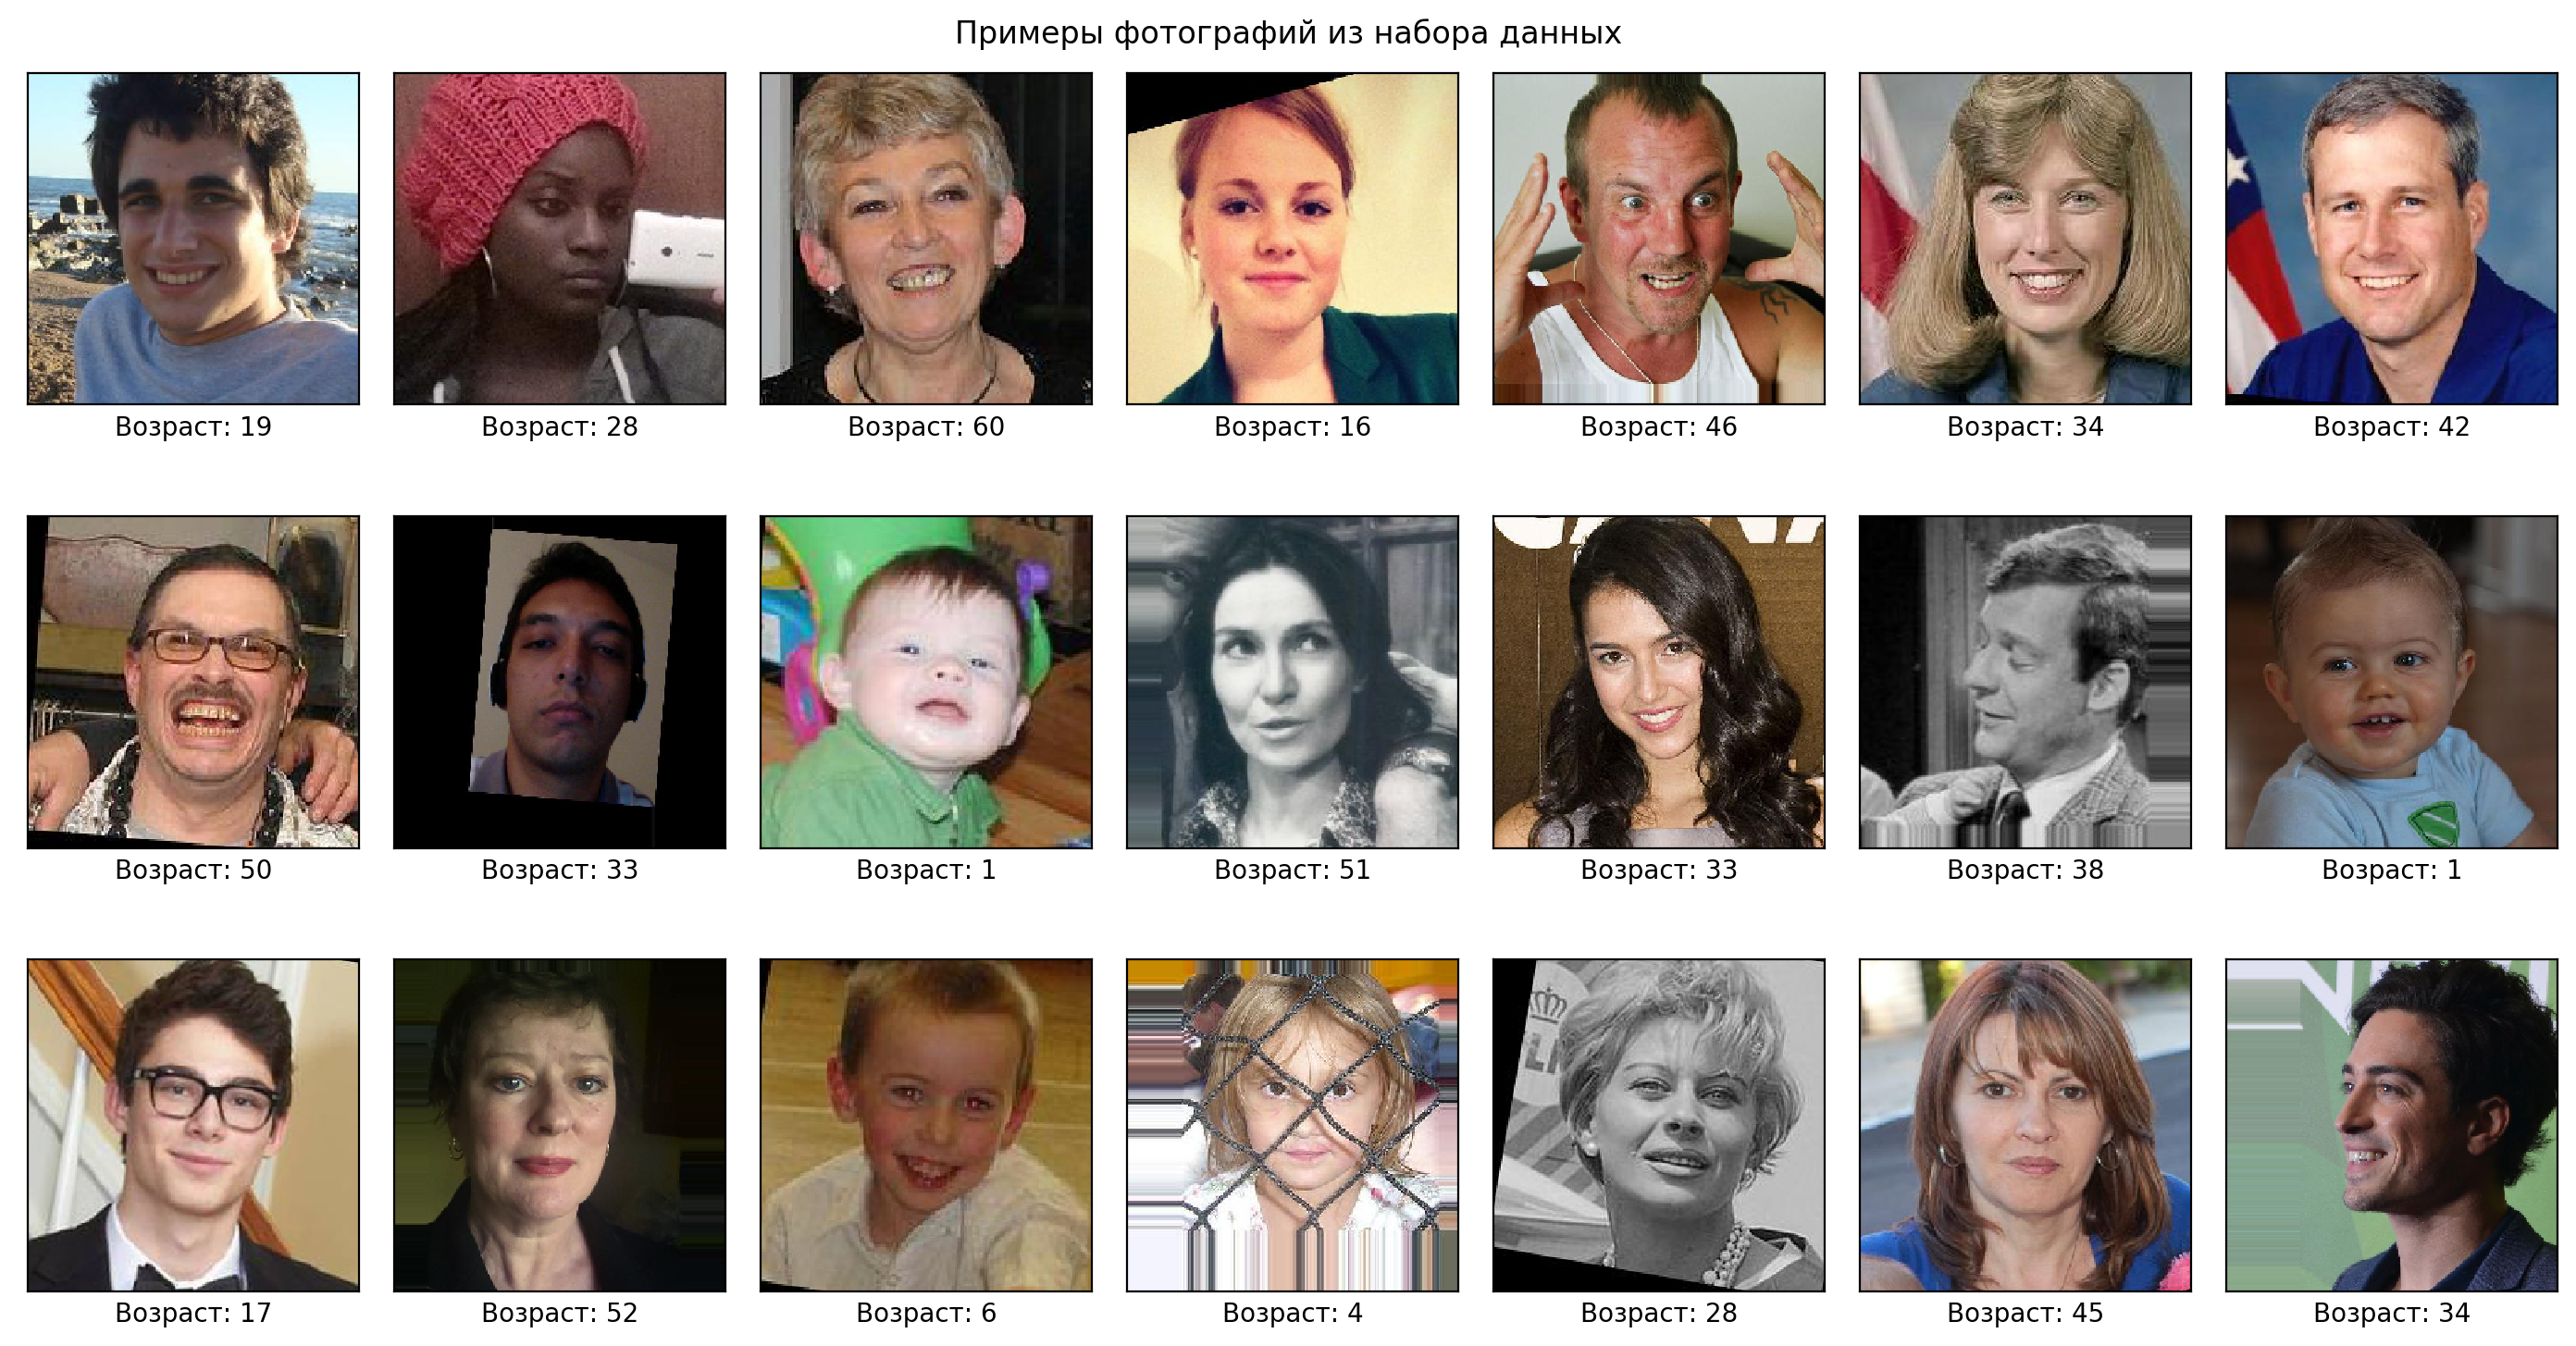

In [10]:
# Рисуем фотографии вместе с возрастом
plt.figure(figsize=(14, 7.5), dpi=200)
for (i, img), label in zip(enumerate(images[0][:21]),
                           images[1]):
    plt.subplot(3, 7, i + 1)
    plt.imshow(img)
    remove_ticks()
    plt.xlabel(f'Возраст: {label}')
plt.suptitle('Примеры фотографий из набора данных')
plt.tight_layout(pad=1)
plt.show()
plt.close()

Как видим, фотографии самые разнообразные:
- С разными цветовыми характеристиками (даже чёрно-белые),
- С разным положением головы (в профиль, в анфас)
- Стоит заметить, что лица выровнены более-менее вертикально. Если датасет собран таким образом, то, возможно, что это важно.

---

## 2. Обучение модели
Мы не будем обучать модель здесь, а просто скопируем код, который задаёт её параметры. Сама модель будет обучена на **GPU** отдельно.
- В качестве модели мы испытаем архитектуру **ResNet50**, предобученную на базе **ImageNet**.
- Верхушкой нашей модели будет полносвязный слой с одним нейроном: для предсказания единственного значения этого достаточно.
- Мы выставили количество эпох, равное *26*: опытным путём мы установили, что примерно такого значения достаточно, чтобы получить отличное качество при валидации.
- В качестве функции потерь зададим **MSE**.
- Мы попробовали разные значения скорости обучения и выяснили, что значение *0.0002* вполне нам подходит, поскольку при длительном обучении и большем learning rate функция потерь начинает "застревать" и колебаться между похожими значениями - а значит, ходить кругами вокруг минимума, но не попадать в него.

```python
# Импортируем необходимые объекты и модули
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam


# Общие параметры для загрузчиков удобно соберём в словари -
# Распакуем их внутри функций
datagen_kws = {'validation_split': .25,
               'rescale': 1./255}

flow_kws = {'dataframe': labels,
            'x_col': 'file_name',
            'y_col': 'real_age',
            'target_size': (224, 224),
            'batch_size': 16,
            'class_mode': 'raw',
            'seed': 42}

# Создание загрузчика для обучающей выборки с отражением фотографий по горизонтали
def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')
    
    train_datagen = ImageDataGenerator(horizontal_flip=True, **datagen_kws)
    
    train_gen_flow = train_datagen.flow_from_dataframe(
        directory=path + 'final_files/',
        subset='training',
        **flow_kws)
    return train_gen_flow

# Создание загрузчика для тестовой выборки
def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')
    test_datagen = ImageDataGenerator(**datagen_kws)
    test_gen_flow = test_datagen.flow_from_dataframe(
        directory=path + 'final_files/',
        subset='validation',
        **flow_kws)
    return test_gen_flow
    

# Создание модели
def create_model(input_shape)
    model = Sequential()
    model.add(ResNet50(weights='imagenet',
                       input_shape=input_shape,
                       include_top=False))
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
     
    optimizer = Adam(lr=0.0002)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    return model

# Параметры обучения
def train_model(model, train_data, test_data, batch_size=None, epochs=26,
                steps_per_epoch=None, validation_steps=None):

    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps)

    return model
```

#### Вывод обучения
```
Train for 356 steps, validate for 119 steps
Epoch 1/26
356/356 - 53s - loss: 185.4940 - mae: 10.0864 - val_loss: 508.1073 - val_mae: 17.4609
Epoch 2/26
356/356 - 43s - loss: 95.8632 - mae: 7.4583 - val_loss: 166.2855 - val_mae: 9.5964
Epoch 3/26
356/356 - 43s - loss: 71.8928 - mae: 6.4664 - val_loss: 96.6071 - val_mae: 7.4425
Epoch 4/26
356/356 - 43s - loss: 54.1224 - mae: 5.6347 - val_loss: 143.9923 - val_mae: 8.9140
Epoch 5/26
356/356 - 43s - loss: 42.9857 - mae: 4.9852 - val_loss: 92.1453 - val_mae: 7.3300
Epoch 6/26
356/356 - 43s - loss: 32.8975 - mae: 4.3849 - val_loss: 81.7359 - val_mae: 6.7748
Epoch 7/26
356/356 - 43s - loss: 29.4003 - mae: 4.1502 - val_loss: 78.4805 - val_mae: 6.6237
Epoch 8/26
356/356 - 43s - loss: 26.0912 - mae: 3.9264 - val_loss: 71.8742 - val_mae: 6.4509
Epoch 9/26
356/356 - 43s - loss: 20.8531 - mae: 3.4722 - val_loss: 70.4140 - val_mae: 6.3213
Epoch 10/26
356/356 - 43s - loss: 16.7880 - mae: 3.1012 - val_loss: 77.8329 - val_mae: 6.7128
Epoch 11/26
356/356 - 43s - loss: 15.2494 - mae: 2.9770 - val_loss: 71.8010 - val_mae: 6.1807
Epoch 12/26
356/356 - 43s - loss: 13.0695 - mae: 2.7491 - val_loss: 71.8252 - val_mae: 6.4880
Epoch 13/26
356/356 - 43s - loss: 13.8871 - mae: 2.8496 - val_loss: 70.9221 - val_mae: 6.2271
Epoch 14/26
356/356 - 43s - loss: 13.0503 - mae: 2.7681 - val_loss: 67.7840 - val_mae: 6.1045
Epoch 15/26
356/356 - 43s - loss: 13.2957 - mae: 2.7854 - val_loss: 71.4511 - val_mae: 6.3518
Epoch 16/26
356/356 - 43s - loss: 14.8604 - mae: 2.9472 - val_loss: 95.7458 - val_mae: 7.1953
Epoch 17/26
356/356 - 43s - loss: 14.6931 - mae: 2.9344 - val_loss: 72.3930 - val_mae: 6.5076
Epoch 18/26
356/356 - 43s - loss: 25.7315 - mae: 3.6501 - val_loss: 121.4975 - val_mae: 8.5611
Epoch 19/26
356/356 - 43s - loss: 26.2345 - mae: 3.8974 - val_loss: 72.1384 - val_mae: 6.5023
Epoch 20/26
356/356 - 44s - loss: 14.7621 - mae: 2.9525 - val_loss: 67.3381 - val_mae: 5.9415
Epoch 21/26
356/356 - 43s - loss: 9.5183 - mae: 2.3474 - val_loss: 67.6967 - val_mae: 6.1501
Epoch 22/26
356/356 - 43s - loss: 7.5077 - mae: 2.0601 - val_loss: 63.2437 - val_mae: 5.8566
Epoch 23/26
356/356 - 43s - loss: 6.3503 - mae: 1.8985 - val_loss: 61.4621 - val_mae: 5.7623
Epoch 24/26
356/356 - 43s - loss: 5.7971 - mae: 1.8272 - val_loss: 63.9879 - val_mae: 6.0414
Epoch 25/26
356/356 - 43s - loss: 6.0248 - mae: 1.8381 - val_loss: 63.4066 - val_mae: 5.9288
Epoch 26/26
356/356 - 43s - loss: 6.5869 - mae: 1.9382 - val_loss: 64.7880 - val_mae: 5.9986
119/119 - 10s - loss: 64.7880 - mae: 5.9986
Test MAE: 5.9986
```

В результате нам удалось достичь MAE чуть меньше *6*, что весьма неплохо и достаточно по условию задачи!

---

## 3. Анализ обученной модели
**Средняя ошибка модели равна 6. Что это может значить?**
- Если мы предложим модели назвать возраст ребёнка на фотографии, то она вряд ли перепутает его с пожилым человеком.
- Сложно сказать, на людях каких возрастов модель ошибается больше всего. У нас нет возможности посмотреть на предсказания в силу реализации обучения, но если бы они у нас имелись, то мы могли бы категоризовать фотографии по возрасту и **найти ошибку для каждой категории**.
- В работу модели могут вносить случайность сами люди с фотографий: **некоторые люди выглядят значительно старше своего возраста**, другие - наоборот, вечно молодые.
- Опять же, перед нами не стоит цель назвать точный возраст конкретного человека. Модель скорее **оценивает** фотографию по тем признакам, которые ей удалось усвоить, и говорит, что "человек с такой-то внешностью тянет на такой-то возраст". Возможно, что в этом смысле модель ведёт себя подобно людям и ошибается в тех же местах, где ошибся бы человек.

**Будет ли от модели польза для бизнеса?**
- Если мы имеем ошибку в 6 лет, то **рискуем не отличить взрослого от ребёнка** в случае с продажей алкоголя. Паспорт всё так же придётся спрашивать.
- С рекомендацией товаров всё лучше: потребности людей не меняются кардинально раз в год, и у нас будет возможность довольно **точно определять крупные возрастные категории** - детей, подростков, молодых, зрелых, пенсионеров и изучать их потребности в автоматическом режиме. Допустим, если у нас есть предсказанный возраст человека и его чек, то мы можем совместить данные о транзакции с возрастом и сделать предположение о том, что тот или иной товар интересен аудитории.

---